In [15]:
# --- ADD THIS CLASS TO THE TOP OF app.py ---
from sklearn.base import BaseEstimator, RegressorMixin

class TweedieEnsemble(BaseEstimator, RegressorMixin):
    def __init__(self, xgb_model, lgb_model, cat_model, weights=(0.34, 0.33, 0.33)):
        self.xgb_model = xgb_model
        self.lgb_model = lgb_model
        self.cat_model = cat_model
        self.weights = weights

    def predict(self, X):
        pred_xgb = self.xgb_model.predict(X)
        pred_lgb = self.lgb_model.predict(X)
        pred_cat = self.cat_model.predict(X)
        return (self.weights[0] * pred_xgb) + (self.weights[1] * pred_lgb) + (self.weights[2] * pred_cat)
# -------------------------------------------

In [16]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 1. LOAD ASSETS
data = joblib.load("processed_step_2.pkl")
model = joblib.load("tweedie_model.joblib")

X_test, y_test, w_test = data['test']
preprocessor = data['preprocessor']
X_test_transformed = preprocessor.transform(X_test)
y_pred = model.predict(X_test_transformed)

# 2. THE GINI COEFFICIENT
def get_gini(actual, pred, weight):
    idx = np.argsort(pred)
    actual_s = actual.iloc[idx]
    weight_s = weight.iloc[idx]
    cum_actual = np.cumsum(actual_s) / np.sum(actual_s)
    cum_weight = np.cumsum(weight_s) / np.sum(weight_s)
    gini = 1 - 2 * np.trapz(cum_actual, cum_weight)
    return gini, cum_actual, cum_weight

gini_val, cum_a, cum_w = get_gini(y_test, y_pred, w_test)

# 3. PREPARE RESULTS DATAFRAME
results_df = pd.DataFrame({'actual': y_test, 'pred': y_pred, 'exposure': w_test})

# 4. LIFT CHART DATA (Deciles)
results_df['decile'] = pd.qcut(results_df['pred'].rank(method='first'), 10, labels=False)
lift_data = results_df.groupby('decile').agg({
    'actual': 'sum',
    'pred': 'sum',
    'exposure': 'sum'
})
lift_data['actual_pp'] = lift_data['actual'] / lift_data['exposure']
lift_data['pred_pp'] = lift_data['pred'] / lift_data['exposure']

# 5. RISK SEGMENTATION (Business View)
results_df['Risk Group'] = pd.qcut(results_df['pred'].rank(method='first'), 3, 
                                 labels=['Low Risk', 'Medium Risk', 'High Risk'])
summary = results_df.groupby('Risk Group').agg({'actual': 'sum', 'exposure': 'sum'})
summary['Loss_Ratio'] = summary['actual'] / summary['exposure']



/Users/willtrevarthen/opt/anaconda3/envs/prem-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/var/folders/wb/7qh6sk893nj541r8z5_8xz0w0000gn/T/ipykernel_26007/3578970549.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = results_df.groupby('Risk Group').agg({'actual': 'sum', 'exposure': 'sum'})


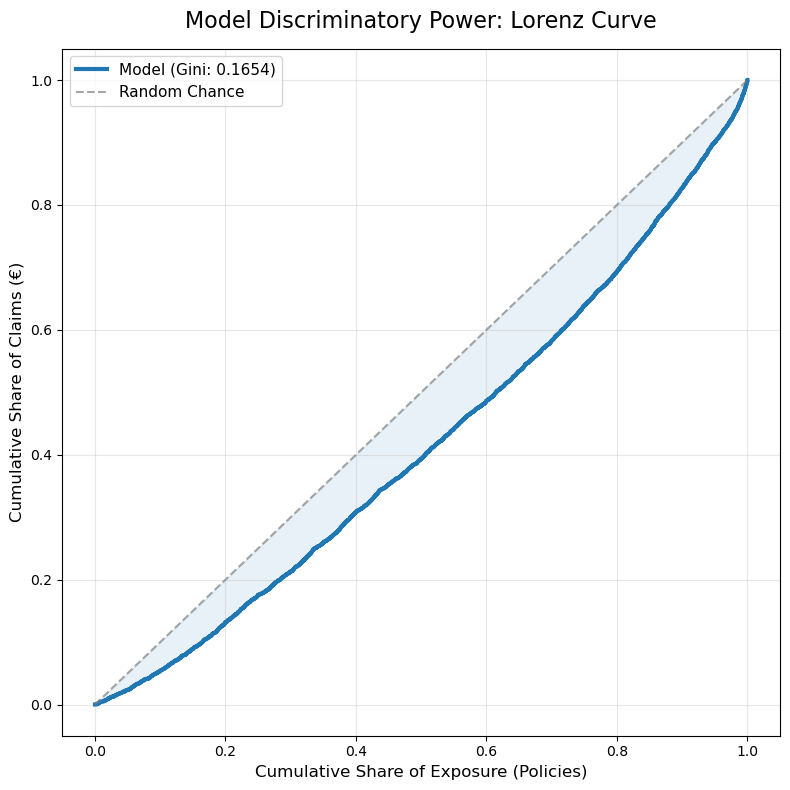

In [17]:
# Standalone cell for the Lorenz Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Plot the Model's Lorenz Curve
plt.plot(cum_w, cum_a, label=f'Model (Gini: {gini_val:.4f})', color='#1f77b4', lw=3)

# Plot the "Random" baseline (45-degree line)
plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.7, label='Random Chance')

# Fill the area for the Gini (Optional, but looks professional)
plt.fill_between(cum_w, cum_w, cum_a, color='#1f77b4', alpha=0.1)

# Formatting
plt.title("Model Discriminatory Power: Lorenz Curve", fontsize=16, pad=15)
plt.xlabel("Cumulative Share of Exposure (Policies)", fontsize=12)
plt.ylabel("Cumulative Share of Claims (€)", fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


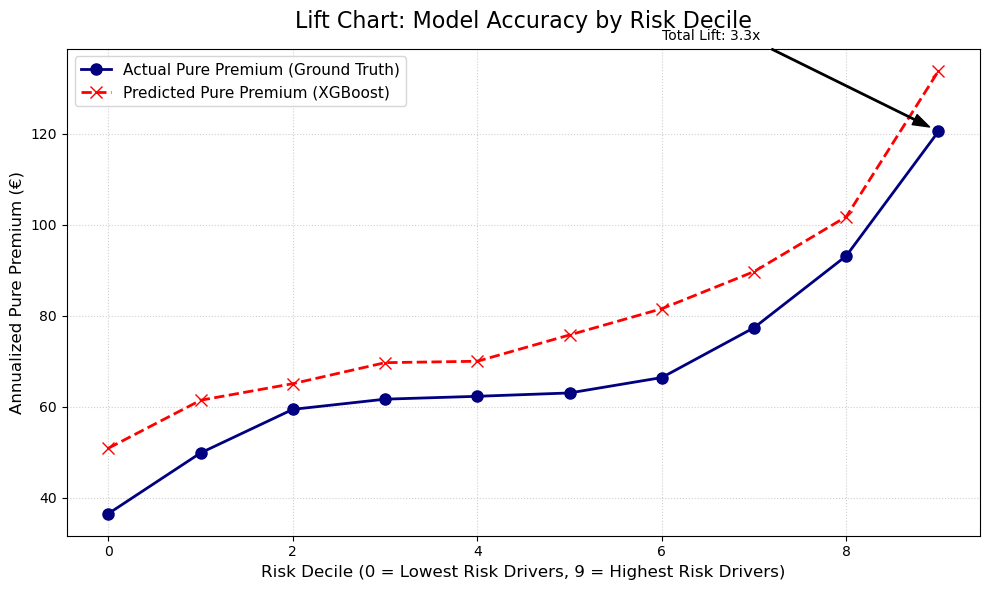

In [18]:
# Standalone cell for the Lift Chart (Pure Premium by Decile)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot Actuals vs Predicted
plt.plot(lift_data.index, lift_data['actual_pp'], marker='o', markersize=8, 
         label='Actual Pure Premium (Ground Truth)', color='navy', linewidth=2)

plt.plot(lift_data.index, lift_data['pred_pp'], marker='x', markersize=8, 
         linestyle='--', label='Predicted Pure Premium (XGBoost)', color='red', linewidth=2)

# Customizing the appearance
plt.title("Lift Chart: Model Accuracy by Risk Decile", fontsize=16, pad=15)
plt.xlabel("Risk Decile (0 = Lowest Risk Drivers, 9 = Highest Risk Drivers)", fontsize=12)
plt.ylabel("Annualized Pure Premium (€)", fontsize=12)

# Adding a grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=11)

# Annotate the 'Lift'
highest_risk = lift_data['actual_pp'].iloc[-1]
lowest_risk = lift_data['actual_pp'].iloc[0]
lift_factor = highest_risk / lowest_risk

plt.annotate(f'Total Lift: {lift_factor:.1f}x', 
             xy=(9, highest_risk), xytext=(6, highest_risk + 20),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

plt.tight_layout()
plt.show()


/var/folders/wb/7qh6sk893nj541r8z5_8xz0w0000gn/T/ipykernel_26007/2321129822.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=summary.index, y=summary['Loss_Ratio'], palette=colors)


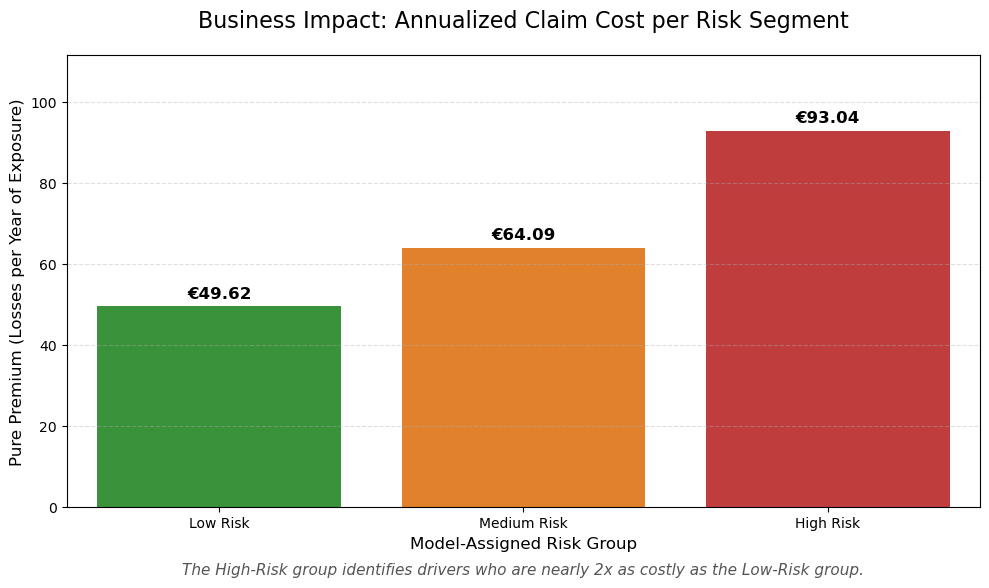

In [19]:
# Standalone cell for the Business Impact (Loss Ratio by Risk Tier)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Define a professional color palette
colors = ['#2ca02c', '#ff7f0e', '#d62728'] # Green (Low), Orange (Med), Red (High)

# Create the bar plot
ax = sns.barplot(x=summary.index, y=summary['Loss_Ratio'], palette=colors)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'€{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')

# Formatting
plt.title("Business Impact: Annualized Claim Cost per Risk Segment", fontsize=16, pad=20)
plt.ylabel("Pure Premium (Losses per Year of Exposure)", fontsize=12)
plt.xlabel("Model-Assigned Risk Group", fontsize=12)
plt.ylim(0, summary['Loss_Ratio'].max() * 1.2) # Add space for labels
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Descriptive Footer
plt.text(0.5, -0.15, "The High-Risk group identifies drivers who are nearly 2x as costly as the Low-Risk group.", 
         ha='center', transform=ax.transAxes, fontsize=11, style='italic', color='#555555')

plt.tight_layout()
plt.show()

In [20]:
# Standalone cell for Model Interpretability (SHAP Beeswarm)
import shap
import matplotlib.pyplot as plt

# 1. Feature Name Mapping (ensuring order matches the ColumnTransformer)
num_names = ['VehPower', 'VehAge', 'DrivAge', 'LogDensity', 'Power_Age_Ratio']
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
bool_names = ['Young_Urban', 'Is_New_Car']
feature_names = num_names + cat_names + bool_names

# 2. SHAP Calculation (using a 100-sample slice for clear visualization)
print("Calculating SHAP values...")
explainer = shap.Explainer(model.predict, shap.sample(X_test_transformed, 50))
shap_values = explainer(X_test_transformed[:100])
shap_values.feature_names = feature_names

# 3. Plotting
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_values, max_display=12, show=False)

# Formatting
plt.title("Model Interpretability: Top Risk Drivers (Global SHAP Impact)", fontsize=16, pad=20)
plt.xlabel("SHAP Value (Impact on Predicted Claim Cost in €)", fontsize=12)
plt.tight_layout()
plt.show()

# Final Summary Printout
print(f"--- Final Conclusion ---")
print(f"Model Gini Score: {gini_val:.4f}")
print(f"Risk Differentiation: High-Risk drivers cost €{summary['Loss_Ratio'].iloc[-1]:.2f} on average, "
      f"vs €{summary['Loss_Ratio'].iloc[0]:.2f} for Low-Risk.")

Calculating SHAP values...


/Users/willtrevarthen/opt/anaconda3/envs/prem-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/willtrevarthen/opt/anaconda3/envs/prem-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/willtrevarthen/opt/anaconda3/envs/prem-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/willtrevarthen/opt/anaconda3/envs/prem-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/willtrevarthen/opt/anaconda3/envs/prem-env/lib/python3.10/site-packages/sklearn/u

KeyboardInterrupt: 